In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

from results.revision.revision_utils import BM_DIR, DATA_PATH
from utils.serialization_ops import load_pickle
from core.data_model import PatientDataSet

patient_dataset:PatientDataSet = load_pickle(DATA_PATH)

In [13]:
candidates = list()
for patient in patient_dataset:
    if not patient.bag_label:
        continue
    
    if patient.snv_data.causal_variant == [("-", "-")]:
        continue
    
    if patient.cnv_data.causal_variant == []:
        continue

    candidates.append(patient)

In [53]:
import mlflow
import torch
from core.networks import MultimodalAttentionMIL
from results.revision.revision_utils import RUN_ASC3_W_RANKNET, TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)
model_path = mlflow.artifacts.download_artifacts("mlflow-artifacts:/6/28fd9b900bd94db7b3f07934dbaf8ae2/artifacts/checkpoint/data/model.pth")
model = torch.load(model_path).eval().to("cuda")

scaler_path = mlflow.artifacts.download_artifacts(f"mlflow-artifacts:/6/28fd9b900bd94db7b3f07934dbaf8ae2/artifacts/checkpoint/scaler.pt")
scaler = torch.load(scaler_path)

In [185]:
from core.datasets import ExSCNVDataset
from core.data_model import PatientDataSet
from results.revision.revision_utils import additional_features
dataset = ExSCNVDataset(
    PatientDataSet(candidates), 
    base_features=['ACMG_bayesian', 'symptom_similarity', 'vcf_info_QUAL', 'inhouse_freq', 'vaf', 'is_incomplete_zygosity'],
    additional_features=['gnomad_gene:pLI', 'gnomad_gene:loeuf', 'SPLICEAI-VALUE', 'wes_AC', 'wgs_AC', 'clinvar_variant:scv:pathogenicity_n_p', 'clinvar_variant:scv:pathogenicity_n_b', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM6', 'PM5', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7'],
    scalers=scaler["scaler"]
)

i = 15
print(candidates[i], candidates[i].snv_data, candidates[i].cnv_data, sep="\n")
(snv_x, cnv_x), instance_label, bag_label = dataset[i]

logit, instance_contribution = model((snv_x, cnv_x))
instance_contribution = instance_contribution.detach().cpu().numpy()
print(torch.sigmoid(logit))

PatientData(sample_id=EPH22-HHOA, bag_label=True, n_snv=237, n_cnv=6)
SNVData(n_variants=237, causal_variant=[('7-117170951-A-G', 'OMIM:219700')])
CNVData(n_variants=6, causal_variant=['7:117144306-117230493'])
tensor([0.9999], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [201]:
import numpy as np
target_patient = candidates[i]
score_indices = np.argsort(instance_contribution)[::-1]

for idx in score_indices[:5]:
    if target_patient.snv_data.n_variants > idx:
        print(target_patient.snv_data.variants[idx])
    else:
        print(target_patient.cnv_data.x[idx-target_patient.snv_data.n_variants]) # ['ACMG_bayesian', 'symptom_similarity', 'num_genes']

Variant(cpra='7-117170951-A-G', acmg_rules=['PVS1_VS', 'PM2_M', 'PM3_P', 'PP5_VS'], disease_id='OMIM:219700', gene_id='OMIM:602421', symbol='', sample_id='', score=-1.0, variant_type='')
Variant(cpra='7-117170951-A-G', acmg_rules=['PVS1_VS', 'PM2_M', 'PM3_P', 'PP5_VS'], disease_id='OMIM:167800', gene_id='OMIM:602421', symbol='', sample_id='', score=-1.0, variant_type='')
Variant(cpra='7-117170951-A-G', acmg_rules=['PVS1_VS', 'PM2_M', 'PM3_P', 'PP5_VS'], disease_id='OMIM:211400', gene_id='OMIM:602421', symbol='', sample_id='', score=-1.0, variant_type='')
[1.3 4.  1. ]
Variant(cpra='7-117170951-A-G', acmg_rules=['PVS1_VS', 'PM2_M', 'PM3_P', 'PP5_VS'], disease_id='OMIM:277180', gene_id='OMIM:602421', symbol='', sample_id='', score=-1.0, variant_type='')


In [202]:
from sklearn.manifold import TSNE
class Encoder(torch.nn.Module):
    def __init__(self, model) -> None:
        super().__init__()
        self.snv_encoder = model.encoder_snv
        self.cnv_encoder = model.encoder_cnv
        self.projector = model.encoded_vec_projection

    def forward(self, x):
        snv, cnv = x
        feat_snv = self.snv_encoder(snv)
        feat_cnv = self.cnv_encoder(cnv)

        return self.projector(torch.concat([feat_snv, feat_cnv]))
    
encoder = Encoder(model).eval()
with torch.no_grad():
    (snv_x, cnv_x), instance_label, bag_label = dataset[i]
    feature = encoder((snv_x, cnv_x)).cpu().numpy()
    
tsne = TSNE(n_components=2, random_state=2)
snv_cnv_embedded = tsne.fit_transform(feature)

/data/heon_dev/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data/heon_dev/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


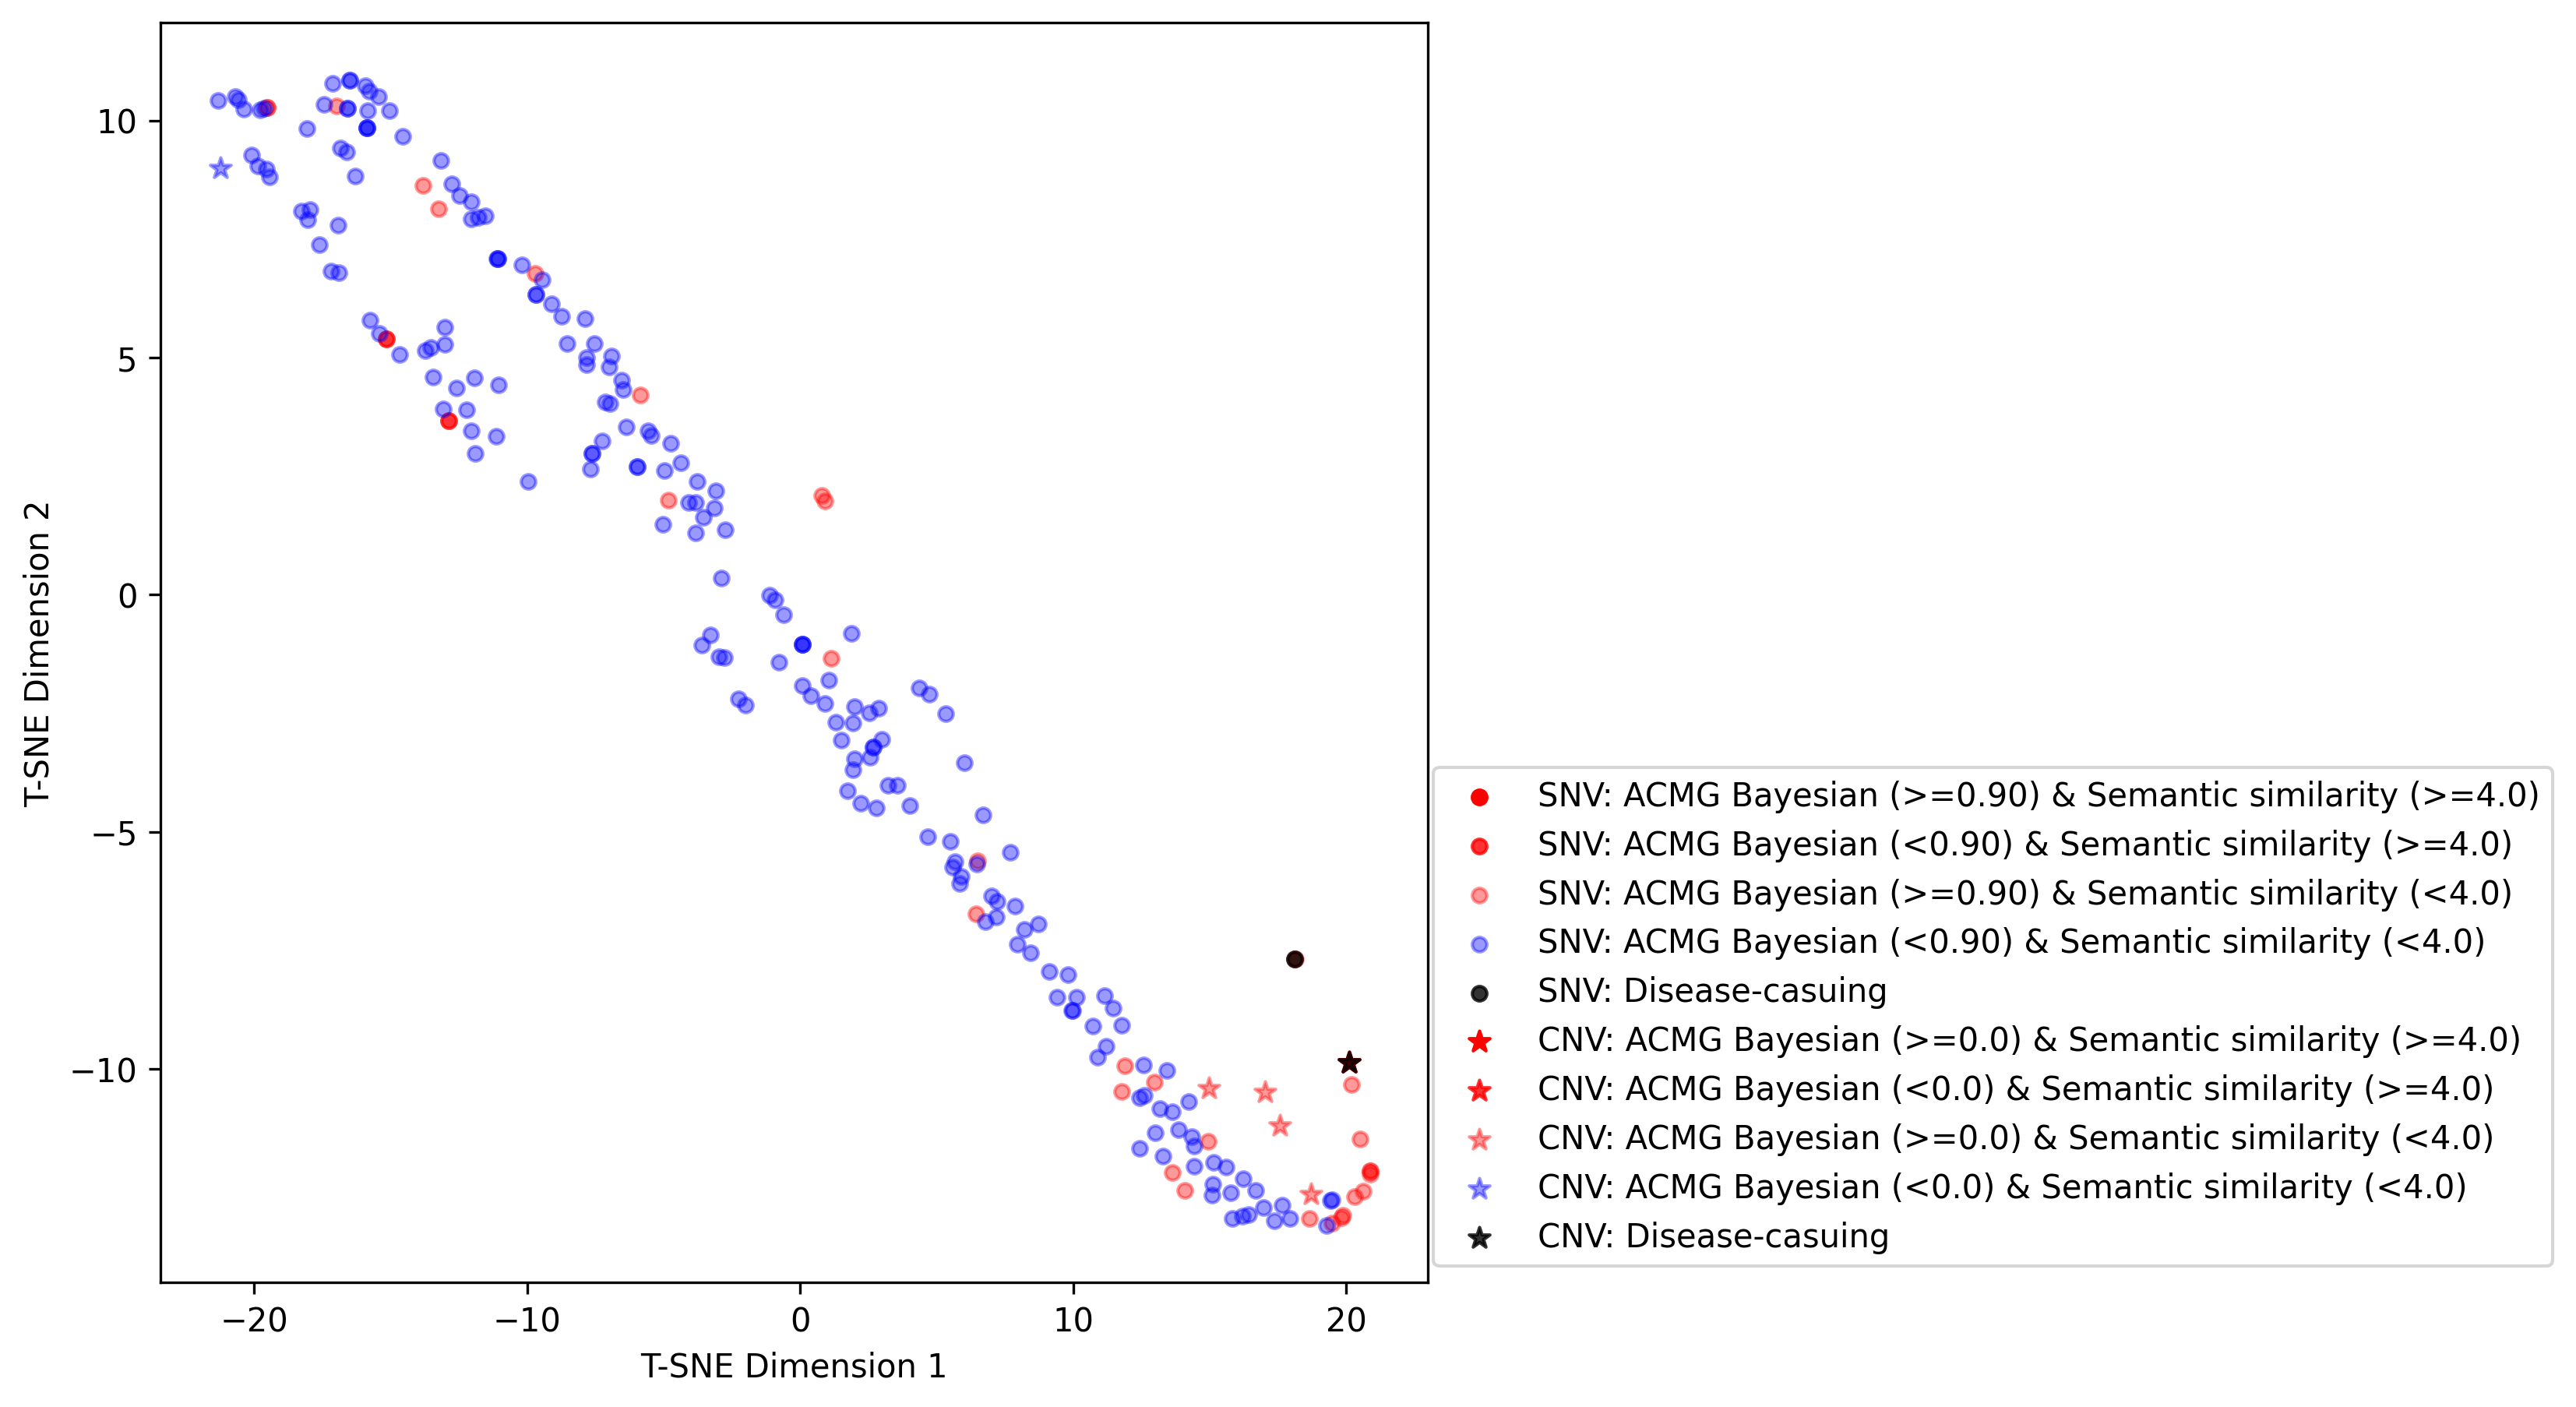

In [204]:
import numpy as np
from matplotlib import pyplot as plt
n_snv = len(dataset.patient_datasets[i].snv_data.x)

bayesian_array = dataset.patient_datasets[i].snv_data.x[:, 0]
symptom_array = dataset.patient_datasets[i].snv_data.x[:, 1]
label_array = dataset.patient_datasets[i].snv_data.y
snv_emb = snv_cnv_embedded[:n_snv]

class1 = np.where((bayesian_array >= 0.90) & (symptom_array >= 4.0))[0]
class2 = np.where((bayesian_array < 0.90) & (symptom_array >= 4.0))[0]
class3 = np.where((bayesian_array >= 0.90) & (symptom_array < 4.0))[0]
class4 = np.where((bayesian_array < 0.90) & (symptom_array < 4.0))[0]

fig, axes = plt.subplots(1, 1, figsize=(7, 7), dpi=300)

axes.scatter(snv_emb[class1, 0], snv_emb[class1, 1], marker='o', color='red', label="SNV: ACMG Bayesian (>=0.90) & Semantic similarity (>=4.0)", alpha=1.0, s=20)
axes.scatter(snv_emb[class2, 0], snv_emb[class2, 1], marker='o', color='red', label="SNV: ACMG Bayesian (<0.90) & Semantic similarity (>=4.0)", alpha=0.8, s=20)
axes.scatter(snv_emb[class3, 0], snv_emb[class3, 1], marker='o', color='red', label="SNV: ACMG Bayesian (>=0.90) & Semantic similarity (<4.0)", alpha=0.4, s=20)
axes.scatter(snv_emb[class4, 0], snv_emb[class4, 1], marker='o', color='blue', label="SNV: ACMG Bayesian (<0.90) & Semantic similarity (<4.0)", alpha=0.4, s=20)
axes.scatter(snv_emb[np.where(label_array), 0], snv_emb[np.where(label_array), 1], marker='o', color='black', label="Disease-casuing", alpha=0.8 , s=20)

bayesian_array = dataset.patient_datasets[i].cnv_data.x[:, 0]
symptom_array = dataset.patient_datasets[i].cnv_data.x[:, 1]
label_array = dataset.patient_datasets[i].cnv_data.y
cnv_emb = snv_cnv_embedded[n_snv:]
class1 = np.where((bayesian_array >= 0) & (symptom_array >= 4.0))[0]
class2 = np.where((bayesian_array < 0) & (symptom_array >= 4.0))[0]
class3 = np.where((bayesian_array >= 0) & (symptom_array < 4.0))[0]
class4 = np.where((bayesian_array < 0) & (symptom_array < 4.0))[0]

axes.scatter(cnv_emb[class1, 0], cnv_emb[class1, 1], marker='*', color='red', label="CNV: ACMG Bayesian (>=0) & Semantic similarity (>=3.0)", alpha=1.0, s=45)
axes.scatter(cnv_emb[class2, 0], cnv_emb[class2, 1], marker='*', color='red', label="CNV: ACMG Bayesian (<0) & Semantic similarity (>=3.0)", alpha=0.8, s=45)
axes.scatter(cnv_emb[class3, 0], cnv_emb[class3, 1], marker='*', color='red', label="CNV: ACMG Bayesian (>=0) & Semantic similarity (<4.0)", alpha=0.4, s=45)
axes.scatter(cnv_emb[class4, 0], cnv_emb[class4, 1], marker='*', color='blue', label="CNV: ACMG Bayesian (<0) & Semantic similarity (<4.0)", alpha=0.4, s=45)
axes.scatter(cnv_emb[np.where(label_array), 0], cnv_emb[np.where(label_array), 1], marker='*', color='black', label="Disease-casuing", alpha=0.8, s=45)

legend_order = [
    "SNV: ACMG Bayesian (>=0.90) & Semantic similarity (>=4.0)",
    "SNV: ACMG Bayesian (<0.90) & Semantic similarity (>=4.0)",
    "SNV: ACMG Bayesian (>=0.90) & Semantic similarity (<4.0)",
    "SNV: ACMG Bayesian (<0.90) & Semantic similarity (<4.0)",
    "SNV: Disease-casuing",
    "CNV: ACMG Bayesian (>=0.0) & Semantic similarity (>=4.0)",
    "CNV: ACMG Bayesian (<0.0) & Semantic similarity (>=4.0)",
    "CNV: ACMG Bayesian (>=0.0) & Semantic similarity (<4.0)",
    "CNV: ACMG Bayesian (<0.0) & Semantic similarity (<4.0)",
    "CNV: Disease-casuing",
]

axes.legend(legend_order, loc="lower right", bbox_to_anchor=(1.9, 0))
axes.set_xlabel("T-SNE Dimension 1")
axes.set_ylabel("T-SNE Dimension 2")

plt.savefig("results/2_4_manifold.png", bbox_inches='tight')